# Imports

In [1]:
%run imports.ipynb

2016-08-28 21:52:48.025407


In [2]:
%run db.ipynb

Starting MySQL database...


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2016-08-28 21:52:48.183494


In [3]:
NOTEBOOK_NAME = 'protherm'
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

# Load data

In [4]:
os.makedirs(NOTEBOOK_NAME, exist_ok=True)

In [5]:
ls ../downloads/

abdellah_2009.tsv.gz  kineticdb.html  ProTherm.dat.gz    taipale/
kineticdb2.html       pfd_all.html    rosetta_ddg.zip
kineticdb_all.html    pfd.html        small_studies.ods


In [6]:
!7za x -aos -bb0 -bd -o"$NOTEBOOK_NAME" ../downloads/ProTherm.dat.gz


7-Zip (a) [64] 15.09 beta : Copyright (c) 1999-2015 Igor Pavlov : 2015-10-16
p7zip Version 15.09 beta (locale=en_CA.UTF-8,Utf16=on,HugeFiles=on,64 bits,64 CPUs x64)

Scanning the drive for archives:
1 file, 1496602 bytes (1462 KiB)

Extracting archive: ../downloads/ProTherm.dat.gz
--
Path = ../downloads/ProTherm.dat.gz
Type = gzip
Headers Size = 23

Everything is Ok

Files: 0
Size:       0
Compressed: 1496602


# Load ProTherm

In [7]:
# Parse protherm into entry chunks
protherm_filename_full = '../downloads/ProTherm.dat.gz'
with gzip.open(protherm_filename_full, 'rt', encoding='cp437') as ifh:
    file_data_chunks = [x.strip() for x in ifh.read().split('//')]

In [8]:
# Convert entry chunks into rows and combine
COLUMNS = []

def get_unique_columns(columns):
    seen = set()
    for c in columns:
        i, c_orig = 0, i
        while c in seen:
            i += 1
            c = c_orig + '_{}'.format(i)
        seen.add(c)
        yield c

def convert_chunks_to_rows(file_data_chunks):
    global COLUMNS
    for i in range(len(file_data_chunks)):
        # Don't return an empty dict for an empty chunk
        if not file_data_chunks[i].strip(' \n'):
            continue
        column = None
        column_old = None
        columns = []
        row = defaultdict(list)
        for line in file_data_chunks[i].split('\n'):
            if line.startswith('***'):
                continue
            column_old = column if column else column_old
            column = line.split(' ')[0]
            column_version = 1
            while column in columns:
                column_version += 1
                column = line.split(' ')[0] + '_{}'.format(column_version)
            value = ' '.join(line.split(' ')[1:]).strip(' \n')
            if not column:
                if not column_old or not value:
                    error_message = (
                        'i: {}, line: {}, column: {}, column_old: {}, value: {}'.format(
                            i, line, column, column_old, value))
                    raise Exception(error_message)
                row[column_old][-1] += ' ' + value
            else:
                row[column].append(value)
                columns.append(column)
        if len(columns) > len(COLUMNS):
            COLUMNS = columns
        yield {key: ','.join(values) for (key, values) in row.items()}

rows = list(convert_chunks_to_rows(file_data_chunks))
df = pd.DataFrame(rows, columns=COLUMNS)

In [9]:
', '.join(COLUMNS)

'NO., PROTEIN, SOURCE, LENGTH, MOL-WEIGHT, PIR_ID, SWISSPROT_ID, E.C.NUMBER, PMD.NO, PDB_wild, PDB_mutant, MUTATION, MUTATED_CHAIN, NO_MOLECULE, SEC.STR., ASA, T, pH, BUFFER_NAME, BUFFER_CONC, ION_NAME_1, ION_CONC_1, ADDITIVES, PROTEIN_CONC, MEASURE, METHOD, dG_H2O, ddG_H2O, dG, ddG, Tm, dTm, dHvH, dHcal, m, Cm, dCp, STATE, REVERSIBILITY, ACTIVITY, ACTIVITY_Km, ACTIVITY_Kcat, ACTIVITY_Kd, REVERSIBILITY_2, ACTIVITY_2, ACTIVITY_Km_2, ACTIVITY_Kcat_2, ACTIVITY_Kd_2, KEY_WORDS, REFERENCE, AUTHOR, REMARKS, RELATED_ENTRIES'

In [10]:
renames = {'E.C.NUMBER': 'ec_number'}
df = df.rename(columns=lambda x: x.replace('.', '_').replace('-', '_').strip('_').lower())

In [11]:
', '.join(df.columns)

'no, protein, source, length, mol_weight, pir_id, swissprot_id, e_c_number, pmd_no, pdb_wild, pdb_mutant, mutation, mutated_chain, no_molecule, sec_str, asa, t, ph, buffer_name, buffer_conc, ion_name_1, ion_conc_1, additives, protein_conc, measure, method, dg_h2o, ddg_h2o, dg, ddg, tm, dtm, dhvh, dhcal, m, cm, dcp, state, reversibility, activity, activity_km, activity_kcat, activity_kd, reversibility_2, activity_2, activity_km_2, activity_kcat_2, activity_kd_2, key_words, reference, author, remarks, related_entries'

In [12]:
df.head(2)

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,,wild,-,1,,,30.0,8.0,borate,10 mM,,,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,,,,,,,,1.47,6.90,,,Unknown,,1.4,675,,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,"
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,,,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,,,,,,,1.20,5.40,,,Unknown,,2.6,0.04,,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,"


In [13]:
print(df.shape)

(25829, 53)


In [14]:
# Replace empty strings with NaNs and remove all-empty rows
df[df == ''] = np.nan
df = df.dropna(subset=['no'])
print(df.shape)

(25823, 53)


In [15]:
df = df[~((df['pdb_wild'] == '1OTR') & (df['mutation'].str.startswith('A 33')))]
print(df.shape)

(25703, 53)


In [16]:
display(df.head(2))

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,"
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,"


In [17]:
def parse_swissprot_id(swissprot_id):
    """
    """
    uniprot_name_conversion = {
        'MK10_HUMAN': 'BRCA1_HUMAN',  # BRCA1
    }
    uniprot_id_conversion = {
        'P69542': 'P69543',
        'P53779': 'P38398',  # BRCA1
    }
    #
    if pd.isnull(swissprot_id):
        return np.nan, np.nan
    row = list(filter(lambda x: x, map(lambda x: x.strip(' ()'), swissprot_id.split())))
    if len(row) == 0:
        uniprot_name, uniprot_id = None, None
    elif len(row) == 1:
        uniprot_name, uniprot_id = row[0], None
    elif len(row) == 2:
        uniprot_name, uniprot_id = row
    else:
        raise Exception('Unknown row: {}, swissprot_id: {}'.format(row, swissprot_id))
    uniprot_name = uniprot_name_conversion.get(uniprot_name, uniprot_name)
    uniprot_id = uniprot_id_conversion.get(uniprot_id, uniprot_id)
    return uniprot_name, uniprot_id

df['uniprot_name_protherm'], df['uniprot_id_protherm'] = zip(*df['swissprot_id'].apply(parse_swissprot_id))

In [18]:
df['protein_name'] = df['protein']

In [19]:
pdb_id_conversion = {
    'érf5v': '3f5v',
    '1bgl': '4v40',
}
df['pdb_id'] = df['pdb_wild'].apply(lambda x: pdb_id_conversion.get(x, x)).str.lower()

In [20]:
df['pdb_chain'] = df['mutated_chain']

In [21]:
df['pdb_mutation'] = df['mutation'].str.upper().apply(lambda x: local.fix_mutations(x))

In [22]:
df.head(2)

,no,protein,source,length,mol_weight,pir_id,swissprot_id,e_c_number,pmd_no,pdb_wild,pdb_mutant,mutation,mutated_chain,no_molecule,sec_str,asa,t,ph,buffer_name,buffer_conc,ion_name_1,ion_conc_1,additives,protein_conc,measure,method,dg_h2o,ddg_h2o,dg,ddg,tm,dtm,dhvh,dhcal,m,cm,dcp,state,reversibility,activity,activity_km,activity_kcat,activity_kd,reversibility_2,activity_2,activity_km_2,activity_kcat_2,activity_kd_2,key_words,reference,author,remarks,related_entries,uniprot_name_protherm,uniprot_id_protherm,protein_name,pdb_id,pdb_chain,pdb_mutation
0,1,Phospholipase A2,Bovine,130,14536.12,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,wild,-,1,NaN,NaN,30.0,8.0,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,9.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.47,6.90,NaN,NaN,Unknown,NaN,1.4,675,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","2,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,WILD
1,2,Phospholipase A2,Bovine,130,14513.08,PSBOA,PA21_BOVIN (P00593),EC 3.4.23.4,A930651,1BP2,NaN,H 48 N,-,1,Helix,17.1,30.0,8.00,borate,10 mM,NaN,NaN,"EDTA (0.1 mM),",5 mM,CD,GdnHCl,6.50,-3.00,NaN,NaN,NaN,NaN,NaN,NaN,1.20,5.40,NaN,NaN,Unknown,NaN,2.6,0.04,NaN,NaN,NaN,NaN,NaN,NaN,catalytic triad; PLA2; conformational stabilit...,"J AM CHEM SOC 115, 8523-8526 (1993) PMID:",Li Y. & Tsai M.-D.,"additive : EDTA(0.1 mM),","1,3,4,",PA21_BOVIN,P00593,Phospholipase A2,1bp2,-,H 48 N


In [23]:
df_bak1 = df.copy()

# Manual curation (df 2)

In [24]:
df = df_bak1.copy()

In [25]:
# Manually correct some errors
key_columns = ['protein_name', 'uniprot_id_protherm', 'uniprot_name_protherm', 'mutation']

# Acylphosphatase
this_subset = df['protein_name'] == 'Acylphosphatase'
display(df[this_subset][key_columns])
df.loc[
    pd.isnull(df['uniprot_name_protherm']) & this_subset,
    'uniprot_name_protherm'] = 'ACYP1_HUMAN'
df.loc[
    pd.isnull(df['uniprot_id_protherm']) & this_subset,
    'uniprot_id'] = 'P07311'
# mutations = df[
#     pd.notnull(df['mutation']) & this_subset]['mutation']
# df.loc[
#     pd.notnull(df['mutation']) & this_subset,
#     'uniprot_mutation'] = mutations
display(df[this_subset][key_columns])


# Alkaline phosphatase
this_subset = df['protein_name'] == 'Alkaline phosphatase'
display(df[this_subset][key_columns])
df.loc[
    pd.isnull(df['uniprot_name_protherm']) & this_subset,
    'uniprot_name_protherm'] = 'PPB_YEAST'
df.loc[
    pd.isnull(df['uniprot_id_protherm']) & this_subset,
    'uniprot_id_protherm'] = 'P11491'
display(df[this_subset][key_columns])


# Arginine kinase
this_subset = df['protein_name'] == 'Arginine kinase'
display(df[this_subset][key_columns])
df.loc[
    pd.isnull(df['uniprot_name_protherm']) & this_subset,
    'uniprot_name_protherm'] = 'KARG_DROME'
df.loc[
    pd.isnull(df['uniprot_id_protherm']) & this_subset,
    'uniprot_id_protherm'] = 'P48610'
display(df[this_subset][key_columns])


# Eglin C
this_subset = df['protein_name'] == 'Eglin C'
display(df[this_subset][key_columns])
df.loc[
    pd.isnull(df['uniprot_name_protherm']) & this_subset,
    'uniprot_name_protherm'] = 'ICIC_HIRME'
df.loc[
    pd.isnull(df['uniprot_id_protherm']) & this_subset,
    'uniprot_id_protherm'] = 'P01051'
display(df[this_subset][key_columns])

,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
5660,Acylphosphatase,P07311,ACYO_HUMAN,wild
5661,Acylphosphatase,P07311,ACYO_HUMAN,wild
5662,Acylphosphatase,P07311,ACYO_HUMAN,wild
5663,Acylphosphatase,P07311,ACYO_HUMAN,wild
5664,Acylphosphatase,P07311,ACYO_HUMAN,wild
5665,Acylphosphatase,P07311,ACYO_HUMAN,wild
5666,Acylphosphatase,P07311,ACYO_HUMAN,wild
5667,Acylphosphatase,P07311,ACYO_HUMAN,wild
5668,Acylphosphatase,P07311,ACYO_HUMAN,wild
5669,Acylphosphatase,P07311,ACYO_HUMAN,wild


,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
5660,Acylphosphatase,P07311,ACYO_HUMAN,wild
5661,Acylphosphatase,P07311,ACYO_HUMAN,wild
5662,Acylphosphatase,P07311,ACYO_HUMAN,wild
5663,Acylphosphatase,P07311,ACYO_HUMAN,wild
5664,Acylphosphatase,P07311,ACYO_HUMAN,wild
5665,Acylphosphatase,P07311,ACYO_HUMAN,wild
5666,Acylphosphatase,P07311,ACYO_HUMAN,wild
5667,Acylphosphatase,P07311,ACYO_HUMAN,wild
5668,Acylphosphatase,P07311,ACYO_HUMAN,wild
5669,Acylphosphatase,P07311,ACYO_HUMAN,wild


,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
3505,Alkaline phosphatase,P00634,PPB_ECOLI,wild
23395,Alkaline phosphatase,NaN,NaN,wild
23396,Alkaline phosphatase,NaN,NaN,I 50 C
23397,Alkaline phosphatase,NaN,NaN,G 51 C
23398,Alkaline phosphatase,NaN,NaN,S 52 C
23399,Alkaline phosphatase,NaN,NaN,S 53 C
23400,Alkaline phosphatase,NaN,NaN,wild
23401,Alkaline phosphatase,NaN,NaN,I 50 C
23402,Alkaline phosphatase,NaN,NaN,G 51 C
23403,Alkaline phosphatase,NaN,NaN,S 52 C


,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
3505,Alkaline phosphatase,P00634,PPB_ECOLI,wild
23395,Alkaline phosphatase,P11491,PPB_YEAST,wild
23396,Alkaline phosphatase,P11491,PPB_YEAST,I 50 C
23397,Alkaline phosphatase,P11491,PPB_YEAST,G 51 C
23398,Alkaline phosphatase,P11491,PPB_YEAST,S 52 C
23399,Alkaline phosphatase,P11491,PPB_YEAST,S 53 C
23400,Alkaline phosphatase,P11491,PPB_YEAST,wild
23401,Alkaline phosphatase,P11491,PPB_YEAST,I 50 C
23402,Alkaline phosphatase,P11491,PPB_YEAST,G 51 C
23403,Alkaline phosphatase,P11491,PPB_YEAST,S 52 C


,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
5283,Arginine kinase,P14208,KARG_HOMGA,wild
22589,Arginine kinase,NaN,NaN,wild
22590,Arginine kinase,NaN,NaN,wild
22591,Arginine kinase,NaN,NaN,wild
22592,Arginine kinase,NaN,NaN,wild
22593,Arginine kinase,NaN,NaN,wild
22594,Arginine kinase,NaN,NaN,wild
22595,Arginine kinase,NaN,NaN,wild
22596,Arginine kinase,NaN,NaN,wild
22597,Arginine kinase,NaN,NaN,wild


,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
5283,Arginine kinase,P14208,KARG_HOMGA,wild
22589,Arginine kinase,P48610,KARG_DROME,wild
22590,Arginine kinase,P48610,KARG_DROME,wild
22591,Arginine kinase,P48610,KARG_DROME,wild
22592,Arginine kinase,P48610,KARG_DROME,wild
22593,Arginine kinase,P48610,KARG_DROME,wild
22594,Arginine kinase,P48610,KARG_DROME,wild
22595,Arginine kinase,P48610,KARG_DROME,wild
22596,Arginine kinase,P48610,KARG_DROME,wild
22597,Arginine kinase,P48610,KARG_DROME,wild


,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
7853,Eglin C,P01051,ICIC_HIRME,wild
9786,Eglin C,P01051,ICIC_HIRME,wild
9787,Eglin C,P01051,ICIC_HIRME,wild
9788,Eglin C,P01051,ICIC_HIRME,wild
9789,Eglin C,P01051,ICIC_HIRME,wild
9790,Eglin C,P01051,ICIC_HIRME,wild
9791,Eglin C,P01051,ICIC_HIRME,wild
9792,Eglin C,P01051,ICIC_HIRME,wild
9793,Eglin C,P01051,ICIC_HIRME,wild
9794,Eglin C,P01051,ICIC_HIRME,wild


,protein_name,uniprot_id_protherm,uniprot_name_protherm,mutation
7853,Eglin C,P01051,ICIC_HIRME,wild
9786,Eglin C,P01051,ICIC_HIRME,wild
9787,Eglin C,P01051,ICIC_HIRME,wild
9788,Eglin C,P01051,ICIC_HIRME,wild
9789,Eglin C,P01051,ICIC_HIRME,wild
9790,Eglin C,P01051,ICIC_HIRME,wild
9791,Eglin C,P01051,ICIC_HIRME,wild
9792,Eglin C,P01051,ICIC_HIRME,wild
9793,Eglin C,P01051,ICIC_HIRME,wild
9794,Eglin C,P01051,ICIC_HIRME,wild


In [26]:
df_bak2 = df.copy()

# Map to UniProt (df 3)

In [27]:
df = df_bak2.copy()

In [28]:
print(df.shape)
print(df.dropna(subset=['pdb_id', 'pdb_mutation']).shape)

(25703, 60)
(21654, 60)


In [29]:
df = df.dropna(subset=['pdb_id', 'pdb_mutation'])

In [30]:
df = df.replace('-', np.nan)

In [31]:
df = df.replace('_', np.nan)

In [32]:
df['uniprot_id'], df['uniprot_mutation'], df['pfam_id'], df['pdb_mutation_sifts'] = (
    zip(*
        df[['pdb_id', 'pdb_chain', 'pdb_mutation', 'uniprot_id_protherm']]
        .apply(lambda x: local.get_uniprot_id_mutation_protherm(*x), axis=1)
))

Could not convert amino acid NH2 to a one letter code!
Could not convert amino acid ACE to a one letter code!
Could not convert amino acid ACE to a one letter code!
Could not convert amino acid ACE to a one letter code!


SIFTS failed to match residue (1znj,  B, H, 10, P01308, 0)


Could not convert amino acid ACE to a one letter code!
Could not convert amino acid ACE to a one letter code!


SIFTS failed to match residue (1lve, nan, S, 29, P01607, 0)
SIFTS failed to match residue (1lve, nan, S, 29, P01607, 0)
Failed to get pdb_mutation (nan) for input: (None, 1lve, nan, V27BL)
SIFTS failed to match residue (1lve, nan, S, 97, P01607, 0)
SIFTS failed to match residue (1lve, nan, Y, 96, P01607, 0)
SIFTS failed to match residue (1lve, nan, S, 29, P01607, 0)
SIFTS failed to match residue (1lve, nan, I, 106, P01607, 0)
SIFTS failed to match residue (1lve, nan, Y, 96, P01607, 0)
SIFTS failed to match residue (1av1, A, W, 3, P02647, 0)
SIFTS failed to match residue (1av1, A, W, 3, P02647, 0)
SIFTS failed to match residue (1av1, A, W, 3, P02647, 0)
SIFTS failed to match residue (1av1, A, W, 3, P02647, 0)
SIFTS failed to match residue (1ttg, nan, Y, 869, P02751, 0)
Failed to get pdb_mutation (A) for input: (None, 1quw, A, D102X)
Failed to get pdb_mutation (A) for input: (None, 1quw, A, D102X)
No mutation mapping available! (2imm, A15L, nan, A15L):
    [{'uniprot_pos': None, 'pdb_cha

Could not convert amino acid PCA to a one letter code!
Could not convert amino acid CSO to a one letter code!


SIFTS failed to match residue (1ten, nan, L, 92, P24821, 0)
SIFTS failed to match residue (1ten, nan, L, 92, P24821, 0)


Could not convert amino acid ACE to a one letter code!


SIFTS failed to match residue (1orc, nan, V, 55, P03036, 0)
SIFTS failed to match residue (1orc, nan, V, 55, P03036, 0)


Could not convert amino acid NH2 to a one letter code!


SIFTS failed to match residue (1c9o, A, L, 67A, P41016, 0)
SIFTS failed to match residue (1c5g, nan, R, 30, P05121, 0)
SIFTS failed to match residue (1c5g, nan, R, 30, P05121, 0)


Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!
Could not convert amino acid TRN to a one letter code!


pdb_chain ('1') and c ('E') do not match!
(['1'], ['ES108S'])
SIFTS failed to match residue (1rro, nan, E, 108E, P02625, 0)
SIFTS failed to match residue (1k42, A, E, 11, P96988, 0)
SIFTS failed to match residue (1k42, A, E, 11, P96988, 0)
SIFTS failed to match residue (1k42, A, D, 160, P96988, 0)
SIFTS failed to match residue (1k42, A, D, 160, P96988, 0)
SIFTS failed to match residue (1k42, A, E, 11, P96988, 0)
SIFTS failed to match residue (1k42, A, E, 11, P96988, 0)
SIFTS failed to match residue (1k42, A, E, 23, P96988, 0)
SIFTS failed to match residue (1k42, A, E, 23, P96988, 0)
SIFTS failed to match residue (1k42, A, E, 26, P96988, 0)
SIFTS failed to match residue (1k42, A, E, 26, P96988, 0)
SIFTS failed to match residue (1k42, A, D, 29, P96988, 0)
SIFTS failed to match residue (1k42, A, D, 29, P96988, 0)
Failed to get pdb_mutation (A) for input: (None, 1am7, A, H31N,H137N,H48TAZ)
Failed to get pdb_mutation (A) for input: (None, 1am7, A, H31N,H137N,H48TAZ)
Failed to get pdb_mutati

Could not convert amino acid PTR to a one letter code!
Could not convert amino acid PTR to a one letter code!
Could not convert amino acid PTR to a one letter code!
Could not convert amino acid PCA to a one letter code!
Could not convert amino acid PCA to a one letter code!
Could not convert amino acid PCA to a one letter code!
Could not convert amino acid PCA to a one letter code!
Could not convert amino acid PCA to a one letter code!
Could not convert amino acid PCA to a one letter code!
Could not convert amino acid PCA to a one letter code!


    Could not fetch uniprot sequence to make sure that AA 'C205' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'C205' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'C236' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'C236' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'C246' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'C246' is correct!    


Could not convert amino acid PCA to a one letter code!
Could not convert amino acid PTR to a one letter code!
Could not convert amino acid NH2 to a one letter code!


SIFTS failed to match residue (1arr, nan, M, 31, P03050, 0)
SIFTS failed to match residue (1arr, nan, Y, 36, P03050, 0)
SIFTS failed to match residue (1arr, nan, L, 40, P03050, 0)
SIFTS failed to match residue (2lzm, nan, R, 137, P00720, 0)
SIFTS failed to match residue (2lzm, nan, R, 137, P00720, 0)
SIFTS failed to match residue (2lzm, nan, R, 137, P00720, 0)
SIFTS failed to match residue (2lzm, nan, R, 137, P00720, 0)
SIFTS failed to match residue (2lzm, nan, R, 137, P00720, 0)
SIFTS failed to match residue (2lzm, nan, R, 137, P00720, 0)
SIFTS failed to match residue (2lzm, nan, R, 137, P00720, 0)
SIFTS failed to match residue (1b26, A, K, 19, P96110, 0)
SIFTS failed to match residue (1uw3, nan, A, 136, P23907, 0)
SIFTS failed to match residue (1uw3, nan, H, 154, P23907, 0)
SIFTS failed to match residue (1uw3, nan, R, 171, P23907, 0)
SIFTS failed to match residue (1uw3, nan, H, 154, P23907, 0)
SIFTS failed to match residue (1uw3, nan, A, 136, P23907, 0)
SIFTS failed to match residue 

Could not convert amino acid PCA to a one letter code!
Could not convert amino acid ABA to a one letter code!
Could not convert amino acid ABA to a one letter code!


    Could not fetch uniprot sequence to make sure that AA 'S65' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'S65' is correct!    
SIFTS failed to match residue (1mbd, nan, I, 86, P02185, 0)
SIFTS failed to match residue (1mbd, nan, I, 86, P02185, 0)
SIFTS failed to match residue (1mbd, nan, I, 86, P02185, 0)
SIFTS failed to match residue (1ubq, nan, K, 72, P62988, 0)
SIFTS failed to match residue (1ubq, nan, K, 72, P62988, 0)
SIFTS failed to match residue (1ubq, nan, K, 72, P62988, 0)
SIFTS failed to match residue (1ubq, nan, K, 72, P62988, 0)
SIFTS failed to match residue (1ubq, nan, K, 72, P62988, 0)
    Could not fetch uniprot sequence to make sure that AA 'T102' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'T102' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'T102' is correct!    
    Could not fetch uniprot sequence to make sure that AA 'T102' is correct!    
    Could not fetch uniprot sequence

Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!
Could not convert amino acid DSN to a one letter code!


SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)
SIFTS failed to match residue (1pga, nan, I, 27, P06654, 0)


In [33]:
df['pdb_mutation_protherm'], df['pdb_mutation'] = df['pdb_mutation'], df['pdb_mutation_sifts']

In [34]:
df['pdb_chain_protherm'] = df['pdb_chain']

df.loc[df['pdb_chain'].isnull() & df['pdb_mutation'].notnull(), 'pdb_chain'] = (
    df.loc[df['pdb_chain'].isnull() & df['pdb_mutation'].notnull(), 'pdb_mutation'].str[0]
)

In [35]:
df[df['pdb_mutation_protherm'] != df['pdb_mutation']][['pdb_mutation_protherm', 'pdb_mutation']].tail(10)

,pdb_mutation_protherm,pdb_mutation
25759,A 132 E,A_A132E
25760,A 132 E,A_A132E
25761,A 132 E,A_A132E
25816,WILD,NaN
25817,L 62 C,A_L62C
25818,A 188 C,A_A188C
25819,L 62 C,A_L62C
25820,A 188 C,A_A188C
25827,WILD,NaN
25828,Y 231 N,A_Y231N


In [36]:
df_bak3 = df.copy()

# Thermodynamic features (df 4)

In [37]:
df = df_bak3.copy()

In [38]:
# Format thermodynamic features
thermodynamic_parameters = [
    'dg_h2o', 'dg', 'tm', 'ddg_h2o', 'ddg', 'dtm', 'dhvh'
]


import re
RANGE_RE = re.compile('(\d+)-(\d+)')


def process_params(value):
    # Skip bad values
    # value = ''.join(row[1:])
    if pd.isnull(value):
        return np.nan
    
    if any(v in value for v in ['<', '>', 'Unknown', 'n.d.', 'NO_MOLECULE', 'dimer']):
        print("Could not convert value '{}' to float because it contains a blacklisted character.".format(value))
        return np.nan
    
    # Clean value
    value = value.replace(',', '').replace('/K', '').rstrip('.').lower()
    
    # Convert to float
    conversion = {
        '': 1,
        'kcal/mol': 1,
        'kcal/mole': 1,
        'cal/mol': 0.001,
        'cal/mole': 0.001,
        'kal/mol': 0.001,
        'kal/mole': 0.001,
        'kj/mol': 0.239001,
        'kj/mole': 0.239001,
    }
    new_value = None
    for suffix, cf in conversion.items():
        try:
            new_value = cf * float(value.strip(suffix))
            break
        except ValueError:
            pass

    match = RANGE_RE.findall(value)
    if len(match) == 1:
        value_min, value_max = [float(x) for x in match[0]]
        if (value_max - value_min) < 4:
            new_value = (value_min + value_max) / 2
            print("Converted '{}' to '{}'...".format(value, new_value))

    # Report errors
    if new_value is None:
        print("Could not convert value '{}' to float! Skipping...".format(value))
        
    return new_value

for column in thermodynamic_parameters:
    print('\n' + column)
    df[column.lower() + '_clean'] = df[column].apply(process_params)


dg_h2o
Could not convert value '< -2.0' to float because it contains a blacklisted character.
Could not convert value '<-3' to float because it contains a blacklisted character.

dg
Could not convert value '10.07 (dimer)' to float because it contains a blacklisted character.
Could not convert value '12.56 (dimer)' to float because it contains a blacklisted character.
Could not convert value '9.97 (dimer)' to float because it contains a blacklisted character.
Could not convert value '12.37 (dimer)' to float because it contains a blacklisted character.

tm
Could not convert value '53.4 (dimer)' to float because it contains a blacklisted character.
Could not convert value '67.3 (dimer)' to float because it contains a blacklisted character.
Could not convert value '< 10.0' to float because it contains a blacklisted character.

ddg_h2o
Could not convert value '< -7.5' to float because it contains a blacklisted character.
Could not convert value '-0.5 kcam(average) = 1646 cal/mol/m was used

In [39]:
# Consensus 'ddg_exp'
df['ddg_exp'] = df[['ddg_h2o_clean', 'ddg_clean']].apply(lambda x: x[0] if pd.notnull(x[0]) else x[1], axis=1)
df['ddg_exp'] = -df['ddg_exp']

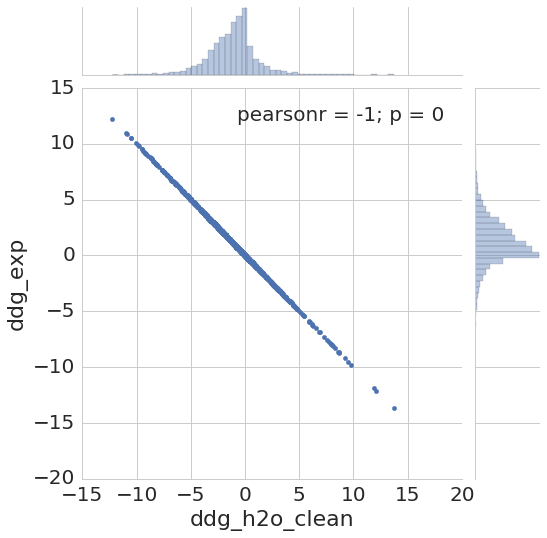

In [40]:
sns.jointplot('ddg_h2o_clean', 'ddg_exp', df, size=8)

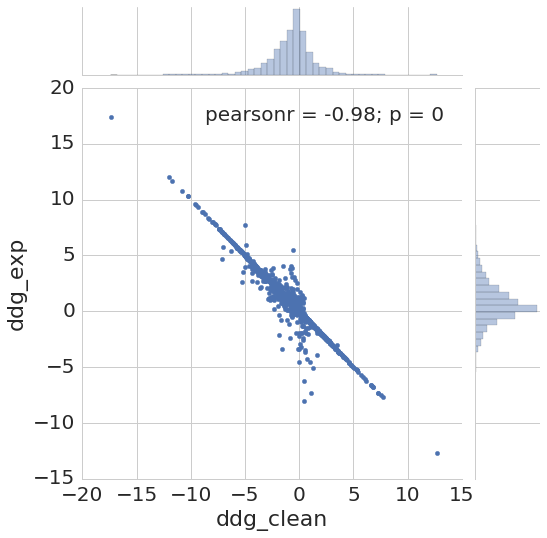

In [41]:
sns.jointplot('ddg_clean', 'ddg_exp', df, size=8)

In [42]:
column_names = [
    'errors', 'protherm_no', 'pdb_id', 'protein_name', 'uniprot_name', 'uniprot_id',
    'mutated_pdb_chain', 'mutation', 'mutation_uniprot'
] + thermodynamic_parameters

missing_columns = [c for c in column_names if c not in df.columns]
print(missing_columns)

['errors', 'protherm_no', 'uniprot_name', 'mutated_pdb_chain', 'mutation_uniprot']


In [43]:
df_bak4 = df.copy()

# Group by PDB / UniProt mutation (df 5)


In [44]:
df = df_bak4.copy()

In [45]:
columns = [
    'pdb_id',
    'pdb_chain',
    'pdb_mutation',
    'uniprot_id',
    'uniprot_mutation',
    'pfam_id',
]

In [46]:
df = (
    df
    [columns + ['ddg_exp']]
    .dropna(subset=['ddg_exp'])
    .fillna('-')
    .groupby(columns)
    ['ddg_exp']
    .agg('mean')
    .reset_index()
    .replace('-', np.nan)
)

In [47]:
df_bak5 = df.copy()

# Remove questionable values (df 6)

In [66]:
df = df_bak5.copy()

In [67]:
protherm_star = pd.read_sql_table('protherm_star', db.engine)

In [68]:
df = (
    df.merge(
        protherm_star
            [['pdb_id', 'pdb_chain', 'pdb_mutation', 'ddg_exp']]
            .rename(columns={'ddg_exp': 'ddg_exp_pstar'}),
        on=['pdb_id', 'pdb_chain', 'pdb_mutation'], 
        how='left')
)

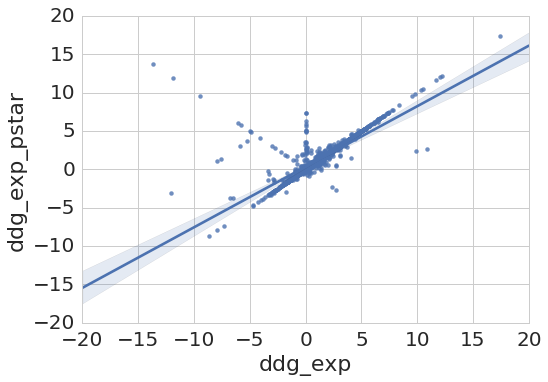

In [69]:
sns.regplot('ddg_exp', 'ddg_exp_pstar', df)

In [70]:
bad_rows = (
    df[
        ((df['ddg_exp'] == -df['ddg_exp_pstar']) & 
         (df['ddg_exp'].abs() > 0.05)) | 
        ((df['ddg_exp'] - df['ddg_exp_pstar']).abs() > 1.0)
    ].index
)

In [71]:
print("Removing {} bad rows (out of {} checked)...".format(len(bad_rows), len(df['ddg_exp_pstar'].dropna())))

Removing 86 bad rows (out of 2584 checked)...


In [72]:
df = df.drop(bad_rows)

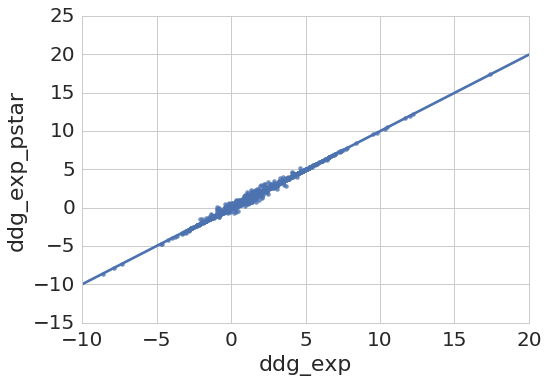

In [73]:
sns.regplot('ddg_exp', 'ddg_exp_pstar', df)

In [74]:
df_bak6 = df.copy()

# Statistics

In [75]:
df = df_bak6.copy()

In [76]:
display(df.head(2))
print(df.shape[0])

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,ddg_exp_pstar
0,1a23,A,A_C30S,P0AEG4,C49S,PF01323,1.8,NaN
1,1a23,A,A_C30S.A_C33S,P0AEG4,C49S.C52S,PF01323,2.0,NaN


4467


In [77]:
assert df[
    (df['uniprot_mutation'].str.len() == 1) & 
    (df['uniprot_mutation'] != '-') & 
    (df['uniprot_mutation'] != '?')
].shape[0] == 0

In [78]:
# Totally failed
df[['uniprot_id', 'uniprot_mutation']].isnull().any(axis=1).sum()

42

In [79]:
# Amino acid mismatch
df['uniprot_mutation'].apply(lambda x: '?' in x if pd.notnull(x) else np.nan).sum()

0

In [80]:
Counter(df['pdb_chain'])

Counter({nan: 28,
         'B': 58,
         'A': 4253,
         '1': 5,
         'O': 3,
         'A, B, B': 1,
         'X': 12,
         'I': 107})

In [81]:
def print_stats(df):
    print2("pdb_id:", 
           df[['pdb_id']].drop_duplicates().shape[0])
    print2("pdb_id / pdb_chain:", 
           df[['pdb_id', 'pdb_chain']].drop_duplicates().shape[0])
    print2("pdb_id / pdb_chain / pdb_mutation:", 
           df[['pdb_id', 'pdb_chain', 'pdb_mutation']].drop_duplicates().shape[0])
    
    print2("uniprot_id:", 
           df[['uniprot_id']].drop_duplicates().shape[0])
    print2("uniprot_id / uniprot_mutation:", 
           df[['uniprot_id', 'uniprot_mutation']].drop_duplicates().shape[0])

    print2("all unique:", df.drop_duplicates().shape[0])
    print2("all:", df.shape[0])

In [82]:
print_stats(df)

pdb_id:                                                     170
pdb_id / pdb_chain:                                         197
pdb_id / pdb_chain / pdb_mutation:                          4467
uniprot_id:                                                 160
uniprot_id / uniprot_mutation:                              4403
all unique:                                                 4467
all:                                                        4467


# Save

In [83]:
columns = [
    'pdb_id',
    'pdb_chain',
    'pdb_mutation',
    'uniprot_id',
    'uniprot_mutation',
    'pfam_id',
]

In [84]:
df = df_bak6.copy()
df_name = 'protherm'

In [85]:
display(df.tail())
print(df.shape)

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,ddg_exp_pstar
4548,5cro,A,A_Y26H,P03040,Y26H,PF09048,-1.9,-1.9
4549,5cro,A,A_Y26L,P03040,Y26L,PF09048,-1.1,-1.1
4550,5cro,A,A_Y26Q,P03040,Y26Q,PF09048,-1.4,-1.4
4551,5cro,A,A_Y26V,P03040,Y26V,PF09048,-0.9,-0.9
4552,5cro,A,A_Y26W,P03040,Y26W,PF09048,0.1,0.1


(4467, 8)


In [86]:
df[df['pdb_chain'].notnull()].head()

,pdb_id,pdb_chain,pdb_mutation,uniprot_id,uniprot_mutation,pfam_id,ddg_exp,ddg_exp_pstar
0,1a23,A,A_C30S,P0AEG4,C49S,PF01323,1.80,NaN
1,1a23,A,A_C30S.A_C33S,P0AEG4,C49S.C52S,PF01323,2.00,NaN
2,1a23,A,A_C33S,P0AEG4,C52S,PF01323,1.10,NaN
3,1a23,A,A_H32L,P0AEG4,H51L,PF01323,-4.95,NaN
4,1a23,A,A_H32S,P0AEG4,H51S,PF01323,-4.40,NaN


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4467 entries, 0 to 4552
Data columns (total 8 columns):
pdb_id              4467 non-null object
pdb_chain           4439 non-null object
pdb_mutation        4425 non-null object
uniprot_id          4425 non-null object
uniprot_mutation    4425 non-null object
pfam_id             3812 non-null object
ddg_exp             4467 non-null float64
ddg_exp_pstar       2498 non-null float64
dtypes: float64(2), object(6)
memory usage: 314.1+ KB


In [88]:
df_name = 'protherm'

assert df['pdb_mutation'].str.contains('_').all()

t = db.import_df(df, df_name)

print(t.name)

t.create_indexes([
        [('pdb_id', 'pdb_chain', 'pdb_mutation'), True],
        [('uniprot_id', 'uniprot_mutation'), False],
    ])

t.add_idx_column()

t.compress()

protherm


File size before: 0.27 MB
File size after: 0.14 MB
File size savings: 0.14 MB (49.45 %)


# Done

In [89]:
print(datetime.datetime.now())

2016-08-28 22:04:02.361531
